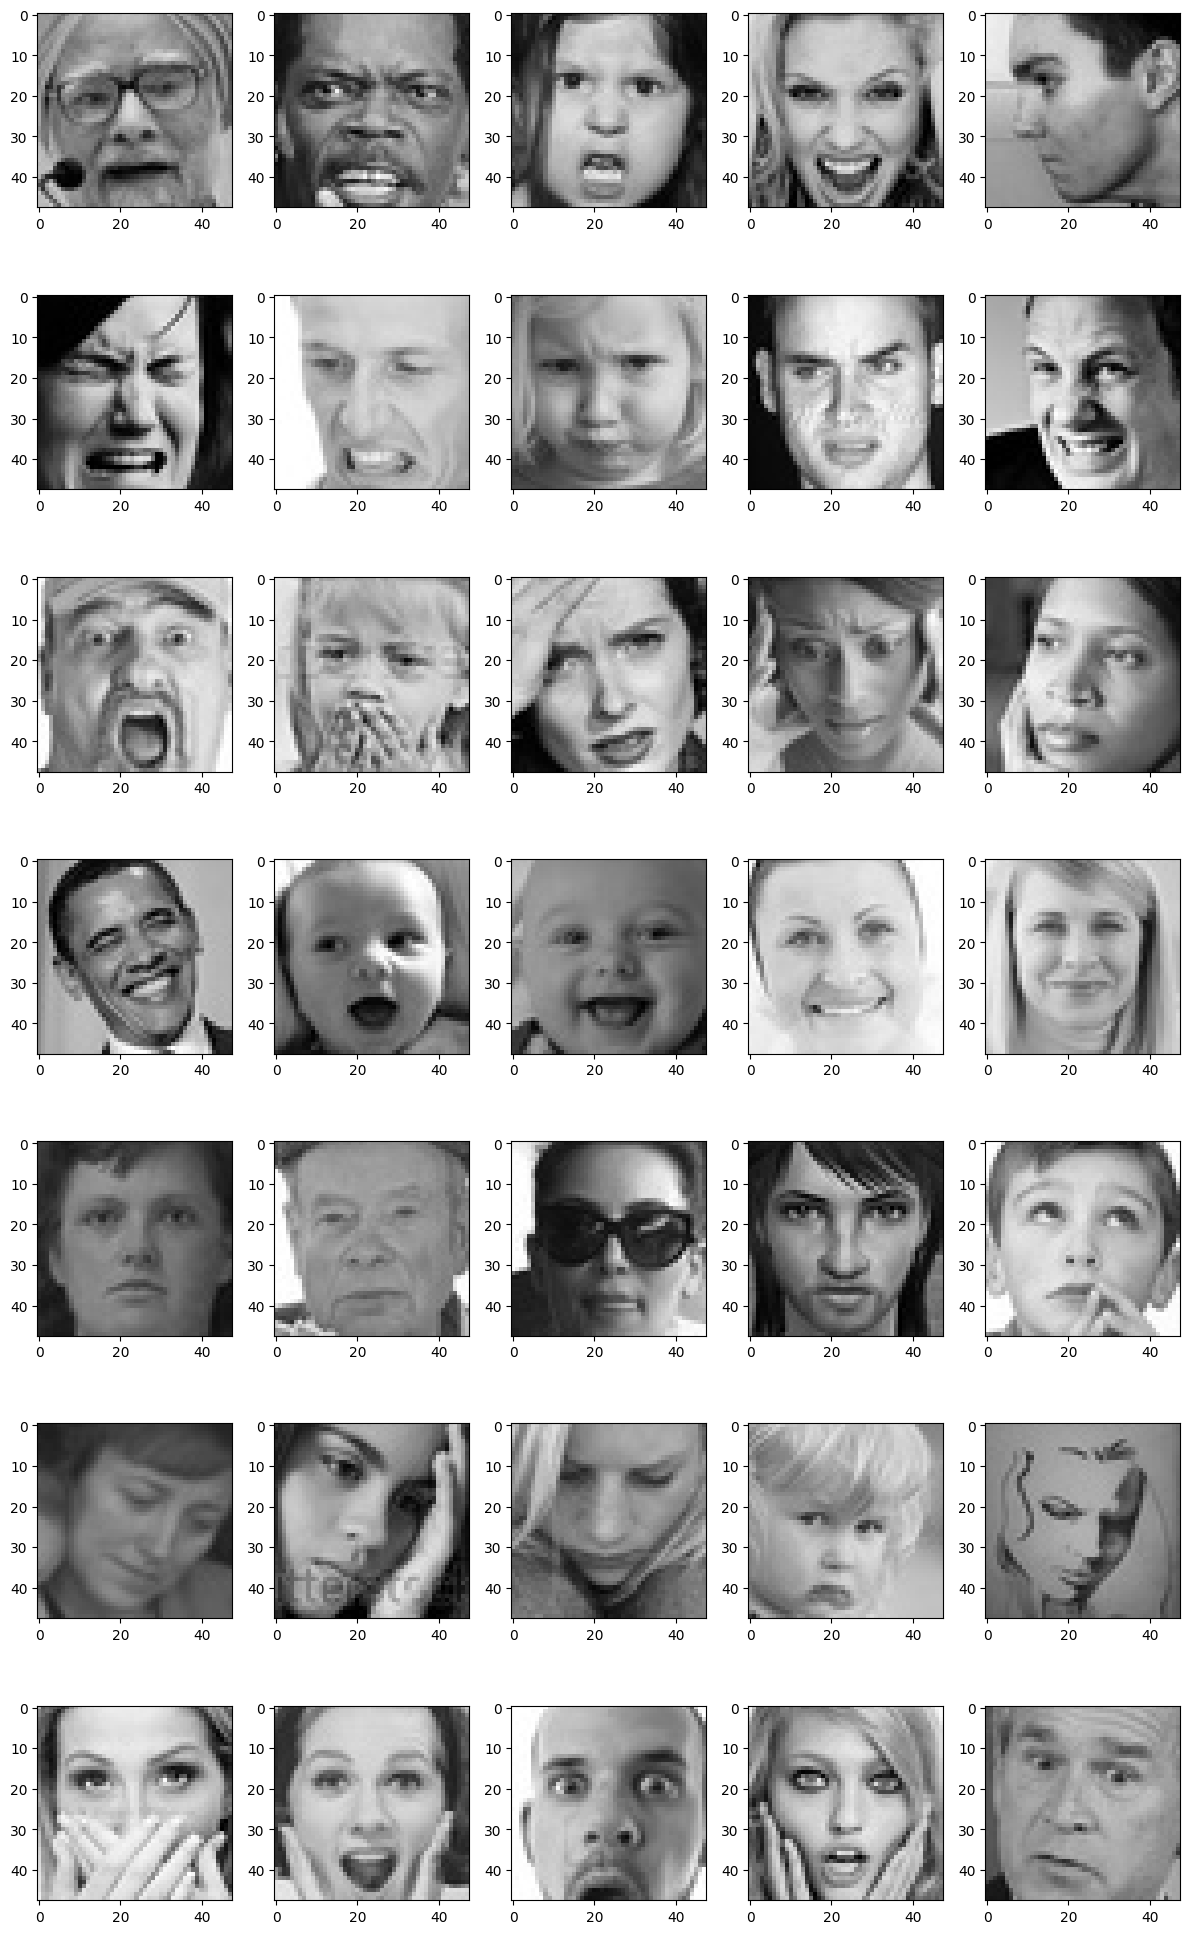

In [1]:
# display some images for every different expression

from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import os

# size of the image: 48*48 pixels
pic_size = 48

# input path for the images
base_path = "../dataset/"

plt.figure(0, figsize=(12, 20))
cpt = 0

for expression in os.listdir(base_path + "train"):
    for i in range(1, 6):
        cpt = cpt + 1
        plt.subplot(7, 5, cpt)
        img = load_img(
            base_path
            + "train/"
            + expression
            + "/"
            + os.listdir(base_path + "train/" + expression)[i],
            target_size=(pic_size, pic_size),
        )
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

## Image augmentation using keras ImageDataGenerator

In [2]:
# building data generator

from keras.preprocessing.image import ImageDataGenerator

batch_size = 128
base_path = "../dataset/"


train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    horizontal_flip=True,
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    base_path + "train",
    target_size=(56, 56),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
)

validation_generator = validation_datagen.flow_from_directory(
    base_path + "validation",
    target_size=(56, 56),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Defining our 4 Convolution and 2 Dense layers model

In [4]:
from keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    BatchNormalization,
    Activation,
    MaxPooling2D,
)
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64, (3, 3), padding="same", input_shape=(56, 56, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128, (5, 5), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation="softmax"))

print(model.summary())

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 56, 56, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       2

c:\Users\niksh\Code\Plaksha Courses\Integrated_Communication_for_Engineering\AIProjectBackEnd\.venv\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
%%time

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

# number of epochs to train the NN
epochs = 50


checkpoint = ModelCheckpoint(
    "model_weights.h5",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode="max",
)
callbacks_list = [checkpoint]

history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=callbacks_list,
)

In [ ]:
# visualise training and testing accuracy and loss


def plot_results(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(24, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, "b", label="Training Accuracy")
    plt.plot(epochs, val_acc, "r", label="Validation Accuracy")
    plt.grid(True)
    plt.legend()
    plt.xlabel("Epoch")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "b", label="Training Loss")
    plt.plot(epochs, val_loss, "r", label="Validation Loss")
    plt.grid(True)
    plt.legend()
    plt.xlabel("Epoch")
    plt.show()


# print best epoch with best accuracy on validation


def get_best_epcoh(history):
    valid_acc = history.history["val_accuracy"]
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc = max(valid_acc)
    print(
        "Best Validation Accuracy Score {:0.5f}, is for epoch {}".format(
            best_acc, best_epoch
        )
    )
    return best_epoch

In [ ]:
plot_results(history)
best_epoch = get_best_epcoh(history)

## Connecting with openCV

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import model_from_json

In [ ]:
model_json_file = "./model.json"
model_weights_file = "./model_weights.h5"
with open(model_json_file, "r") as json_file:
    loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(model_weights_file)

In [ ]:
face_cascade = cv2.CascadeClassifier("./haarcascade_frontalface_default.xml")

In [ ]:
import copy

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    img = copy.deepcopy(frame)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for x, y, w, h in faces:
        fc = gray[y : y + h, x : x + w]

        roi = cv2.resize(fc, (48, 48))
        pred = loaded_model.predict(roi[np.newaxis, :, :, np.newaxis])
        text_idx = np.argmax(pred)
        text_list = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
        if text_idx == 0:
            text = text_list[0]
        if text_idx == 1:
            text = text_list[1]
        elif text_idx == 2:
            text = text_list[2]
        elif text_idx == 3:
            text = text_list[3]
        elif text_idx == 4:
            text = text_list[4]
        elif text_idx == 5:
            text = text_list[5]
        elif text_idx == 6:
            text = text_list[6]
        cv2.putText(
            img, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 255), 2
        )
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)

    cv2.imshow("frame", img)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()